In [48]:
import pandas as pd
import pyinaturalist
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import os
import datetime
from dateutil.tz import tzutc, tzoffset
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import scipy.stats as stats
from thefuzz import fuzz
from thefuzz import process
from astropy.stats import jackknife_resampling, jackknife_stats
from matplotlib.lines import Line2D
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':24, 'weight': 'bold'})
# rc('text', usetex=True)

tqdm.pandas()

# 1. Import Data from NZ Stats
Data obtained from: https://nztcs.org.nz

In [2]:
# import nztcs_export.xlsx
nz_stats = pd.read_excel('nztcs_export.xlsx')

/Users/kommunizm/Library/Python/3.9/lib/python/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
# count number of unique species in nz_stats
species_count_nz_stats = nz_stats['Current Species Name'].nunique()
print(f'Number of unique species in nz_stats: {species_count_nz_stats}')

Number of unique species in nz_stats: 15456


In [4]:
nz_stats.iloc[0]['Current Species Name']

'"Bangia 1" sp. A (WELT A026705; BCH sensu Sutherland et al. 2011)'

## Important note
After finishing our project, we called with Dr. Dennis Gordon, a veteran specialist on NZ biodiversity, who directed us to NZOR, which is a repository of all organisms observed in NZ. This database spans over many more species than we were able to obtain from NZTCS. He told us that NZTCS only focuses on endemic and indigeneous species, whereas the NZOR simply counts all of them (even in zoos). In order to properly asssess the ability of iNaturalist to estimate biodiversity, we recommend to compare it to NZOR. The data from NZOR can be retrieved here: http://nzor.org.nz/

# 2. Import Data from iNaturalist
Data obtained from the latest snapshot (01.02.2024) from GBIF: https://www.gbif.org/occurrence/search?country=NZ&dataset_key=50c9509d-22c7-4a22-a47d-8c48425ef4a7

In [5]:
# import inat_nz.csv
inat_nz = pd.read_csv('inat_nz.csv', delimiter='\t', encoding='utf-8')

In [6]:
# this is a bug from GBIF. Unclear why, but must be done for our analysis
# replace rows with NaN in 'class' with 'Actinopterygii'
inat_nz['class'] = inat_nz['class'].fillna('Actinopterygii')

In [7]:
# count number of unique species in inat_nz
species_count_inat = inat_nz['scientificName'].nunique()
print(f'Number of unique species, incl. subspecies, in inat_nz: {species_count_inat}')

Number of unique species, incl. subspecies, in inat_nz: 15710


# 3. Compare the iNaturalist dataset with NZ Stats
NZ Stats doesn't have a number of observations, so only the number of species can be derived from this dataset.\
Therefore, we need to get the number of species from the iNaturalist dataset.\
Both datasets are then compared on the number of species that have been observed, per kingdom. Also per class comparison is performed for the Animal kingdom.

In [8]:
# create a table with all the unique scientificName, their counts, and kingdom
inat_nz_species_count_df = inat_nz['scientificName'].value_counts()
inat_nz_species_count_df = inat_nz_species_count_df.reset_index()
inat_nz_species_count_df.columns = ['scientificName', 'count']
inat_nz_species_count_df['kingdom'] = inat_nz['kingdom']
# for scientificName, get only the first two words
inat_nz_species_count_df['scientificName'] = inat_nz_species_count_df['scientificName'].str.split().str[:2].str.join(' ')
# drop all non-alphanumeric characters, except for spaces
inat_nz_species_count_df['scientificName'] = inat_nz_species_count_df['scientificName'].str.replace('[^a-zA-Z0-9 ]', '')
inat_nz_species_count_df = inat_nz_species_count_df.drop_duplicates()
inat_nz_species_count_df = inat_nz_species_count_df.reset_index(drop=True)
inat_nz_species_count_df.head()

,scientificName,count,kingdom
0,Hemiphaga novaeseelandiae,9629,Plantae
1,Cordyline australis,4767,Fungi
2,Prosthemadera novaeseelandiae,4331,Plantae
3,Chroicocephalus novaehollandiae,4226,Plantae
4,"Ichneutica Meyrick,",4093,Animalia


### In this part, we want to assign a more precise conservation status to iNaturalist species, since iNaturalist export only contains Threatened=True/False. 
We wrote two functions, find_match_fuzzy() and find_match(), which both aim to match strings between iNaturalists' scientificName and NZ Stats' Current Species Name columns. In our case, the fuzzy matching did not perform much better (and sometimes even worse) than the str.contains, so we decided not to use it to avoid false positives and false negatives. But we suggest trying out the fuzzy matching on a new dataset, as it might perform better.

In [9]:
# def find_match_fuzzy(y):
#     try:
#         fuzziness = nz_stats['Current Species Name'].apply(lambda x: fuzz.ratio(x, y))
#         # fuzziness = fuzziness[fuzziness > 85]
#         if fuzziness.empty:
#             fuzziness_id = fuzziness.idxmax()
#             return [nz_stats['Status'][fuzziness_id], nz_stats['Current Species Name'][fuzziness_id], fuzziness.max()]
#         else:
#             fuzziness_id = fuzziness.idxmax()
#             return [nz_stats['Status'][fuzziness_id], nz_stats['Current Species Name'][fuzziness_id], fuzziness.max()]
#     except:
#         return ['err','err','err']

In [10]:
# # apply the function to the column
# results = inat_nz_species_count_df['scientificName'].progress_apply(find_match_fuzzy)
# # convert results to a dataframe
# results = pd.DataFrame(results.to_list(), columns=['status', 'best_match', 'fuzziness'])
# inat_nz_species_count_df['status'] = results['status']
# inat_nz_species_count_df['best_match'] = results['best_match']
# inat_nz_species_count_df['fuzziness'] = results['fuzziness']

In [11]:
# define the lambda apply_progress function separately to handle exceptions
def find_match(x):
    try:
        return nz_stats[nz_stats['Current Species Name'].str.contains(x, case=False)]['Status'].values[0]
    except:
        return ''

In [12]:
inat_nz_species_count_df['status'] = inat_nz_species_count_df['scientificName'].progress_apply(find_match)

  0%|          | 0/15679 [00:00<?, ?it/s]

 16%|█▌        | 2448/15679 [00:22<01:39, 133.26it/s]/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_34780/3988510288.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  return nz_stats[nz_stats['Current Species Name'].str.contains(x, case=False)]['Status'].values[0]
100%|██████████| 15679/15679 [02:24<00:00, 108.69it/s]


In [13]:
inat_nz_species_count_df.head(10)

,scientificName,count,kingdom,status
0,Hemiphaga novaeseelandiae,9629,Plantae,Not Threatened
1,Cordyline australis,4767,Fungi,Not Threatened
2,Prosthemadera novaeseelandiae,4331,Plantae,Not Threatened
3,Chroicocephalus novaehollandiae,4226,Plantae,Declining
4,"Ichneutica Meyrick,",4093,Animalia,
5,Microsorum pustulatum,4027,Plantae,
6,Melicytus ramiflorus,3990,Animalia,Naturally Uncommon
7,Haematopus unicolor,3881,Animalia,Recovering
8,Coprosma robusta,3828,Animalia,Not Threatened
9,Hemiphaga novaeseelandiae,3682,Plantae,Not Threatened


In [14]:
# count how many empty cells in the status column
print('Approximate overlap in observed species between iNaturalist and NZ Stats: ', (inat_nz_species_count_df['status'] != '').sum(), '(', (inat_nz_species_count_df['status'] != '').sum() / inat_nz_species_count_df.shape[0] * 100, '%)')

Approximate overlap in observed species between iNaturalist and NZ Stats:  5245 ( 33.45238854518783 %)


# 4. Plot the saturation curve for iNaturalist Data
Saturation curve in this case represents the Cumulative Number of Species Observed vs Cumulative Number of Observations. You can expect this saturation curve to have a shape of $V_R(n) = K(n)^\beta$, where $V_R$ is the number of unique species observed in number of observations $n$. $K$ and $\beta$ are free parameters determined empirically. We will first obtain this plot, and then proceed to estimating these two parameters, so as to determine the expected number of species in New Zealand.

In [15]:
# convert eventDate to year-month format tz-aware
inat_nz['eventDate'] = pd.to_datetime(inat_nz['eventDate'], utc=True, format='mixed')
# set all the days to the first day of the month
inat_nz['eventDate'] = inat_nz['eventDate'].dt.to_period('M').dt.to_timestamp()

/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_34780/857952218.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  inat_nz['eventDate'] = inat_nz['eventDate'].dt.to_period('M').dt.to_timestamp()


In [16]:
# get all the first occurences of a unique species and their date
first_occurences = inat_nz.groupby('scientificName')['eventDate'].min()
# sort by date
first_occurences = first_occurences.sort_values()
first_occurences = first_occurences.reset_index()
first_occurences.columns = ['scientificName', 'first_occurence']
# group by month and count the number of occurences
first_occurences = first_occurences.groupby('first_occurence').size()
first_occurences = first_occurences.reset_index()
# get cumulative sum
first_occurences['cumulative'] = first_occurences[0].cumsum()
first_occurences['first_occurence'] = first_occurences['first_occurence'].dt.to_period('M').dt.to_timestamp()

In [17]:
# create a table with all the unique scientificName, their counts, and kingdom
inat_nz_species_count_df = inat_nz['scientificName'].value_counts()
inat_nz_species_count_df = inat_nz_species_count_df.reset_index()
inat_nz_species_count_df.columns = ['scientificName', 'count']
inat_nz_species_count_df['kingdom'] = inat_nz['kingdom']
# for scientificName, get only the first two words
inat_nz_species_count_df['scientificName'] = inat_nz_species_count_df['scientificName'].str.split().str[:2].str.join(' ')
# drop all non-alphanumeric characters, except for spaces
inat_nz_species_count_df['scientificName'] = inat_nz_species_count_df['scientificName'].str.replace('[^a-zA-Z0-9 ]', '')
inat_nz_species_count_df = inat_nz_species_count_df.drop_duplicates()
inat_nz_species_count_df = inat_nz_species_count_df.reset_index(drop=True)
inat_nz_species_count_df.head()

,scientificName,count,kingdom
0,Hemiphaga novaeseelandiae,9629,Plantae
1,Cordyline australis,4767,Fungi
2,Prosthemadera novaeseelandiae,4331,Plantae
3,Chroicocephalus novaehollandiae,4226,Plantae
4,"Ichneutica Meyrick,",4093,Animalia


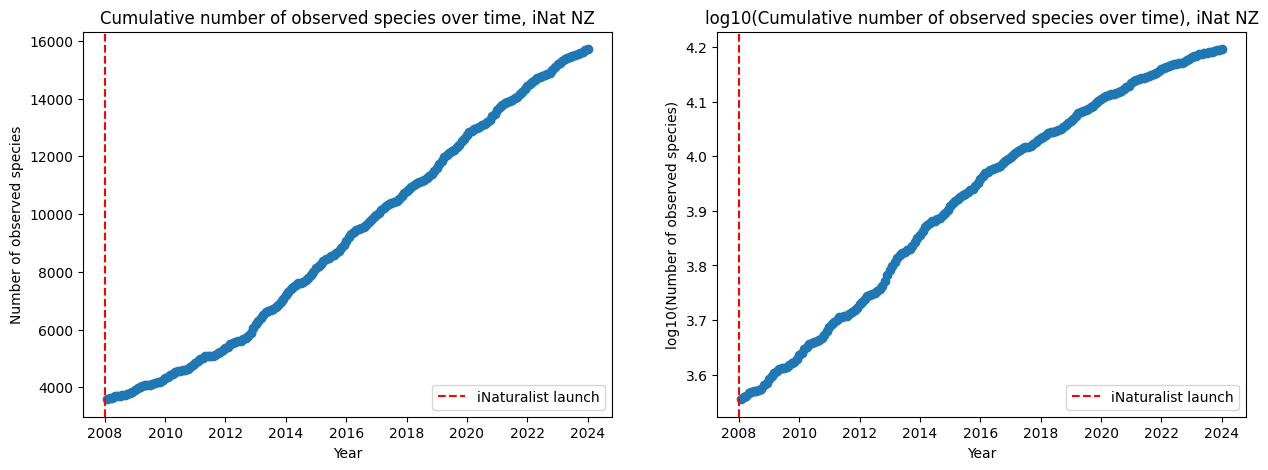

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot the cumulative number of species over time
ax[0].plot_date(first_occurences['first_occurence'], first_occurences['cumulative'])
# ax[0].set_xlim(datetime.date(2008, 1, 1), datetime.date(2023, 1, 1))
# plot vline at 2008
ax[0].axvline(datetime.date(2008, 1, 1), color='r', linestyle='--', label='iNaturalist launch')
ax[0].legend()
ax[0].set_title('Cumulative number of observed species over time, iNat NZ')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of observed species')

# plot the cumulative number of species over time
ax[1].plot_date(first_occurences['first_occurence'], np.log10(first_occurences['cumulative']))
# ax[1].set_xlim(datetime.date(2008, 1, 1), datetime.date(2023, 1, 1))
# plot vline at 2008
ax[1].axvline(datetime.date(2008, 1, 1), color='r', linestyle='--', label='iNaturalist launch')
ax[1].legend()
ax[1].set_title('log10(Cumulative number of observed species over time), iNat NZ')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('log10(Number of observed species)')

plt.show()


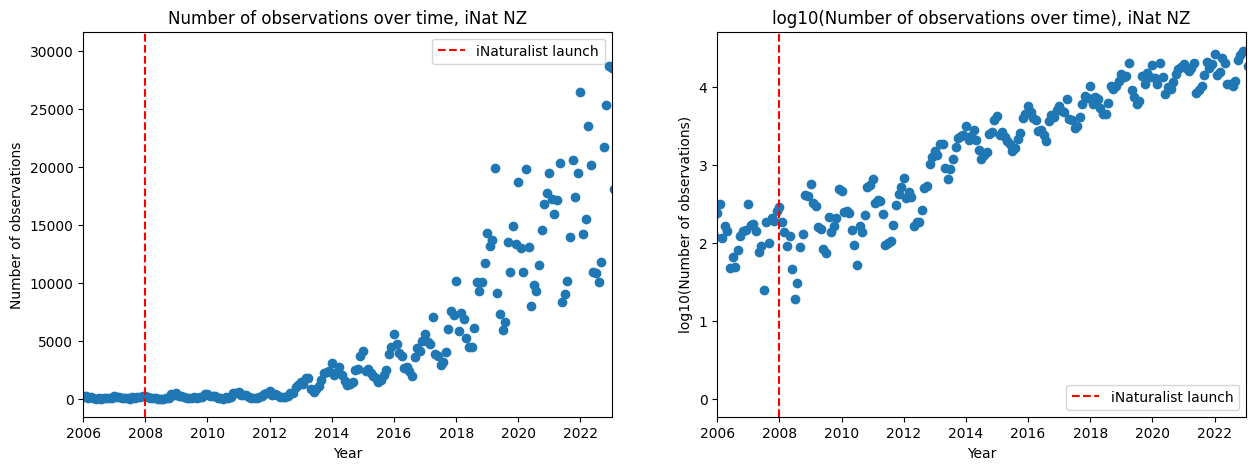

In [50]:
# group inat_nz observations by eventdate
inat_nz_date = inat_nz.groupby('eventDate').size()
inat_nz_date = inat_nz_date.reset_index()
inat_nz_date.columns = ['eventDate', 'count']
# create 2 images side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# plot the number of observations over time, eventDate is a date
ax[0].plot_date(inat_nz_date['eventDate'], inat_nz_date['count'])
ax[0].set_xlim(datetime.date(2006, 1, 1), datetime.date(2023, 1, 1))
ax[0].axvline(datetime.date(2008, 1, 1), color='r', linestyle='--', label='iNaturalist launch')
ax[0].legend()
ax[0].set_title('Number of observations over time, iNat NZ')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of observations')

ax[1].plot_date(inat_nz_date['eventDate'], np.log10(inat_nz_date['count']))
ax[1].set_xlim(datetime.date(2006, 1, 1), datetime.date(2023, 1, 1))
ax[1].axvline(datetime.date(2008, 1, 1), color='r', linestyle='--', label='iNaturalist launch')
ax[1].legend()
ax[1].set_title('log10(Number of observations over time), iNat NZ')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('log10(Number of observations)')
plt.show()

In [51]:
# drop all dates before 2008 in inat_nz_date
inat_nz_date = inat_nz_date[inat_nz_date['eventDate'] > datetime.datetime(2008, 1, 1)]
# drop all dates before 2008 in first_occurences
first_occurences = first_occurences[first_occurences['first_occurence'] > datetime.datetime(2008, 1, 1)]

In [52]:
# add cumulative count column to inat_nz_date
inat_nz_date['cumulative'] = inat_nz_date['count'].cumsum()

In [53]:
# figsize and dpi
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=300)
plt.gca().set_facecolor('None')
plt.plot(inat_nz_date['cumulative'], first_occurences['cumulative'], lw=6, color='#64cbe4', label='iNaturalist saturation curve')
# plot horizontal line for the number of unique species from nz_stats
plt.axhline(y=species_count_nz_stats, color='#cc5153', linestyle='--', label='Number of species in NZTCS', lw=6)
# add ACE estimate (21675.049627791563) -- see below
plt.axhline(y=21675, color='black', linestyle='--', label='ACE estimate, iNaturalist', lw=6)
# add Chao1 estimate (19843) -- see below
plt.axhline(y=19843, color='grey', linestyle='--', label='Chao1 estimate, iNaturalist', lw=6)
plt.legend(loc='lower right')
# adjust origin to 0
# plt.xlim(0, 1.3e6)
# plt.ylim(0, 22e3)
# yticks = ax.get_yticks()
# yticks = [int(ytick/1000) for ytick in yticks]
# ax.set_yticklabels(yticks)
# plt.xlabel('Number of observations', fontweight='bold', fontsize=36)
# plt.ylabel('Number of species, $×10^3$', fontweight='bold', fontsize=36)
# # turn on grid in light grey
# plt.grid(True, color='lightgrey')
# plt.show()

# Calculate the Expected Total number of Species
We only have abundance data (meaning that we don't have any sampling taking place). This restricts us in using different estimators, such as Chao2 or ICE, but if your data does include sampling, then you can try those. They're described in: Gotelli, Nicholas J., and Robert K. Colwell. “Estimating Species Richness.” Biological Diversity: Frontiers in Measurement and Assessment. A. E. Magurran and B. J. McGill, Eds., Oxford University Press, Oxford, UK, 2010, pp. 39–54.

### 1. Using Chao1

$S_{obs}$ = number of observations \
$f_k$ = number of species observed k times

$S_{Chao1} = S_{obs} + \frac{f_1^2}{2f_2} $

In [54]:
# number of species observed + 1 observation / 2 observations
S_obs = len(inat_nz_species_count_df)
f1 = len(inat_nz_species_count_df[inat_nz_species_count_df['count'] == 1])
f2 = len(inat_nz_species_count_df[inat_nz_species_count_df['count'] == 2])

# chao1 estimator
print('Chao1 Estimate: ', S_obs + f1**2 / (2*f2))

Chao1 Estimate:  19843.049627791563


### 2. Using ACE
$ S_{rare} = \sum _{k=1} ^{cutoff} f_k $ \
$ S_{abundant} = S_{obs} - S_{rare} $ \
$ N_{rare} = \sum _{k=1} ^{cutoff} k * f_k $ \
$ C_{ACE} = 1 - \frac{f_1}{N_rare} $ \
$ \gamma = max[\frac{S_{ACE}}{C_{ACE}} * \frac{\sum _{k=1} ^{10} k(k-1)*f_k}{N_{rare}*(N_{rare}-1)}-1, 0] $

In [55]:
def calculate_ace(abundances, rare_cutoff=10):
    # Filter rare species based on the cutoff
    rare_species_abundances = np.array([abundance for abundance in abundances if abundance < rare_cutoff])
    
    # Calculate components for ACE
    S_rare = len(rare_species_abundances)  # Number of rare species
    N_rare = sum(rare_species_abundances)  # Total number of individuals in rare species

    S_abund = len(abundances)-S_rare       # Total number of abundant species

    f1 = sum(rare_species_abundances == 1)  # Number of singletons

    
    # Estimate sample coverage for rare species
    C_ACE = 1 - f1 / N_rare

    # rare combinations
    rare_combinations = 0
    for i in range(1, rare_cutoff):
        rare_combinations += i * (i-1) * sum(rare_species_abundances == i)
    
    gamma = S_rare / C_ACE * (rare_combinations / (N_rare * (N_rare - 1)))-1

    gamma = max(0, gamma)
    
    # Calculate ACE
    S_ACE = S_abund + S_rare / C_ACE +  f1 / C_ACE * gamma
    
    return S_ACE

# Example usage

ace_estimate = calculate_ace(inat_nz_species_count_df['count'], rare_cutoff=3)
print(f"ACE Estimate: {ace_estimate}")

ACE Estimate: 21675.049627791563


# 5. Plot the saturation curve per kingdom.

In [56]:
# get scientificName, eventDate, kingdom, and class
inat_observations_by_kingdom = inat_nz[['scientificName', 'eventDate', 'kingdom', 'class']]
# for scientificName, get only the first two words and drop all non-alphanumeric characters, except for spaces
inat_observations_by_kingdom['scientificName'] = inat_observations_by_kingdom['scientificName'].str.split().str[:2].str.join(' ')
inat_observations_by_kingdom['scientificName'] = inat_observations_by_kingdom['scientificName'].str.replace('[^a-zA-Z0-9 ]', '')

# convert eventDate to year-month format tz-aware
inat_observations_by_kingdom['eventDate'] = pd.to_datetime(inat_observations_by_kingdom['eventDate'], utc=True)
# set all the days to the first day of the month
inat_observations_by_kingdom['eventDate'] = inat_observations_by_kingdom['eventDate'].dt.to_period('M').dt.to_timestamp()

/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_34780/3663792764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inat_observations_by_kingdom['scientificName'] = inat_observations_by_kingdom['scientificName'].str.split().str[:2].str.join(' ')
/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_34780/3663792764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inat_observations_by_kingdom['scientificName'] = inat_observations_by_kingdom['scientificName'].str.replace('[^a-zA-Z0-9 ]', '

In [57]:
def sat_curve_kingdom(kingdom):
    inat_observations_plants = inat_observations_by_kingdom[inat_observations_by_kingdom['kingdom']==kingdom]
    inat_observations_plants.reset_index(drop=True, inplace=True)

    # get number of rows per eventDate
    inat_observations_plants_count_observations = inat_observations_plants.groupby('eventDate').size()
    inat_observations_plants_count_observations = inat_observations_plants_count_observations.reset_index()
    inat_observations_plants_count_observations.columns = ['eventDate', 'count']
    # add cumulative sum
    inat_observations_plants_count_observations['cumulative'] = inat_observations_plants_count_observations['count'].cumsum()
    # create 2 images side by side
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # plot the number of observations over time, eventDate is a date
    ax[0].plot_date(inat_observations_plants_count_observations['eventDate'], inat_observations_plants_count_observations['count'])
    ax[0].set_xlim(datetime.date(2006, 1, 1), datetime.date(2023, 1, 1))
    ax[0].axvline(datetime.date(2008, 1, 1), color='r', linestyle='--', label='iNaturalist launch')
    ax[0].legend()
    ax[0].set_title('Number of observations over time, NZ')
    ax[0].set_xlabel('Year')
    ax[0].set_ylabel('Number of observations')

    ax[1].plot_date(inat_observations_plants_count_observations['eventDate'], np.log10(inat_observations_plants_count_observations['count']))
    ax[1].set_xlim(datetime.date(2006, 1, 1), datetime.date(2023, 1, 1))
    ax[1].axvline(datetime.date(2008, 1, 1), color='r', linestyle='--', label='iNaturalist launch')
    ax[1].legend()
    ax[1].set_title('log10(Number of observations over time), NZ')
    ax[1].set_xlabel('Year')
    ax[1].set_ylabel('log10(Number of observations)')
    # plot suptitle
    plt.suptitle(kingdom)
    plt.show()

    # get all the first occurences of a unique species and their date
    inat_observations_plants_count_species = inat_observations_plants.groupby('scientificName')['eventDate'].min()
    # sort by date
    inat_observations_plants_count_species = inat_observations_plants_count_species.sort_values()
    inat_observations_plants_count_species = inat_observations_plants_count_species.reset_index()
    inat_observations_plants_count_species.columns = ['scientificName', 'first_occurence']
    # group by month and count the number of occurences
    inat_observations_plants_count_species = inat_observations_plants_count_species.groupby('first_occurence').size()
    inat_observations_plants_count_species = inat_observations_plants_count_species.reset_index()
    # get cumulative sum
    inat_observations_plants_count_species['cumulative'] = inat_observations_plants_count_species[0].cumsum()
    inat_observations_plants_count_species['first_occurence'] = inat_observations_plants_count_species['first_occurence'].dt.to_period('M').dt.to_timestamp()

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # plot the cumulative number of species over time
    ax[0].plot_date(inat_observations_plants_count_species['first_occurence'], inat_observations_plants_count_species['cumulative'])
    ax[0].set_xlim(datetime.date(2006, 1, 1), datetime.date(2023, 1, 1))
    # plot vline at 2008
    ax[0].axvline(datetime.date(2008, 1, 1), color='r', linestyle='--', label='iNaturalist launch')
    ax[0].legend()
    ax[0].set_title('Cumulative number of observed species over time, NZ')
    ax[0].set_xlabel('Year')
    ax[0].set_ylabel('Number of observed species')

    # plot the cumulative number of species over time
    ax[1].plot_date(inat_observations_plants_count_species['first_occurence'], np.log10(inat_observations_plants_count_species['cumulative']))
    ax[1].set_xlim(datetime.date(2006, 1, 1), datetime.date(2023, 1, 1))
    # plot vline at 2008
    ax[1].axvline(datetime.date(2008, 1, 1), color='r', linestyle='--', label='iNaturalist launch')
    ax[1].legend()
    ax[1].set_title('log10(Cumulative number of observed species over time), NZ')
    ax[1].set_xlabel('Year')
    ax[1].set_ylabel('log10(Number of observed species)')
    # plot suptitle
    plt.suptitle(kingdom)
    plt.show()

    # drop all dates before 2008 in inat_nz_date
    inat_observations_plants_count_observations = inat_observations_plants_count_observations[inat_observations_plants_count_observations['eventDate'] > datetime.datetime(2008, 1, 1)]
    # drop all dates before 2008 in first_occurences
    inat_observations_plants_count_species = inat_observations_plants_count_species[inat_observations_plants_count_species['first_occurence'] > datetime.datetime(2008, 1, 1)]
    # get the minimum length of the two
    min_length = min(len(inat_observations_plants_count_observations), len(inat_observations_plants_count_species))
    plt.plot(inat_observations_plants_count_observations['cumulative'][0:min_length], inat_observations_plants_count_species['cumulative'][0:min_length])
    # plot horizontal line for the number of unique species from nz_stats
    # calculate the number of species with kingdom = kingdom in nz_stats
    species_count_nz_stats_kingdom = nz_stats[nz_stats['Kingdom'] == kingdom]['Current Species Name'].nunique()
    plt.axhline(y=species_count_nz_stats_kingdom, color='r', linestyle='--', label='Number of species in NZ Stats')
    plt.title('Number of species vs number of observations')
    plt.legend()
    plt.xlabel('Number of observations')
    plt.ylabel('Number of species')
    # plot suptitle
    plt.suptitle(f'{kingdom} observations on iNaturalist NZ')
    plt.show()
    # calculate_ace(inat_observations_plants_count_observations['count'])


/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_34780/631068452.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks)
/var/folders/07/cyf36j6s41qc8nccrvkfbly40000gn/T/ipykernel_34780/631068452.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


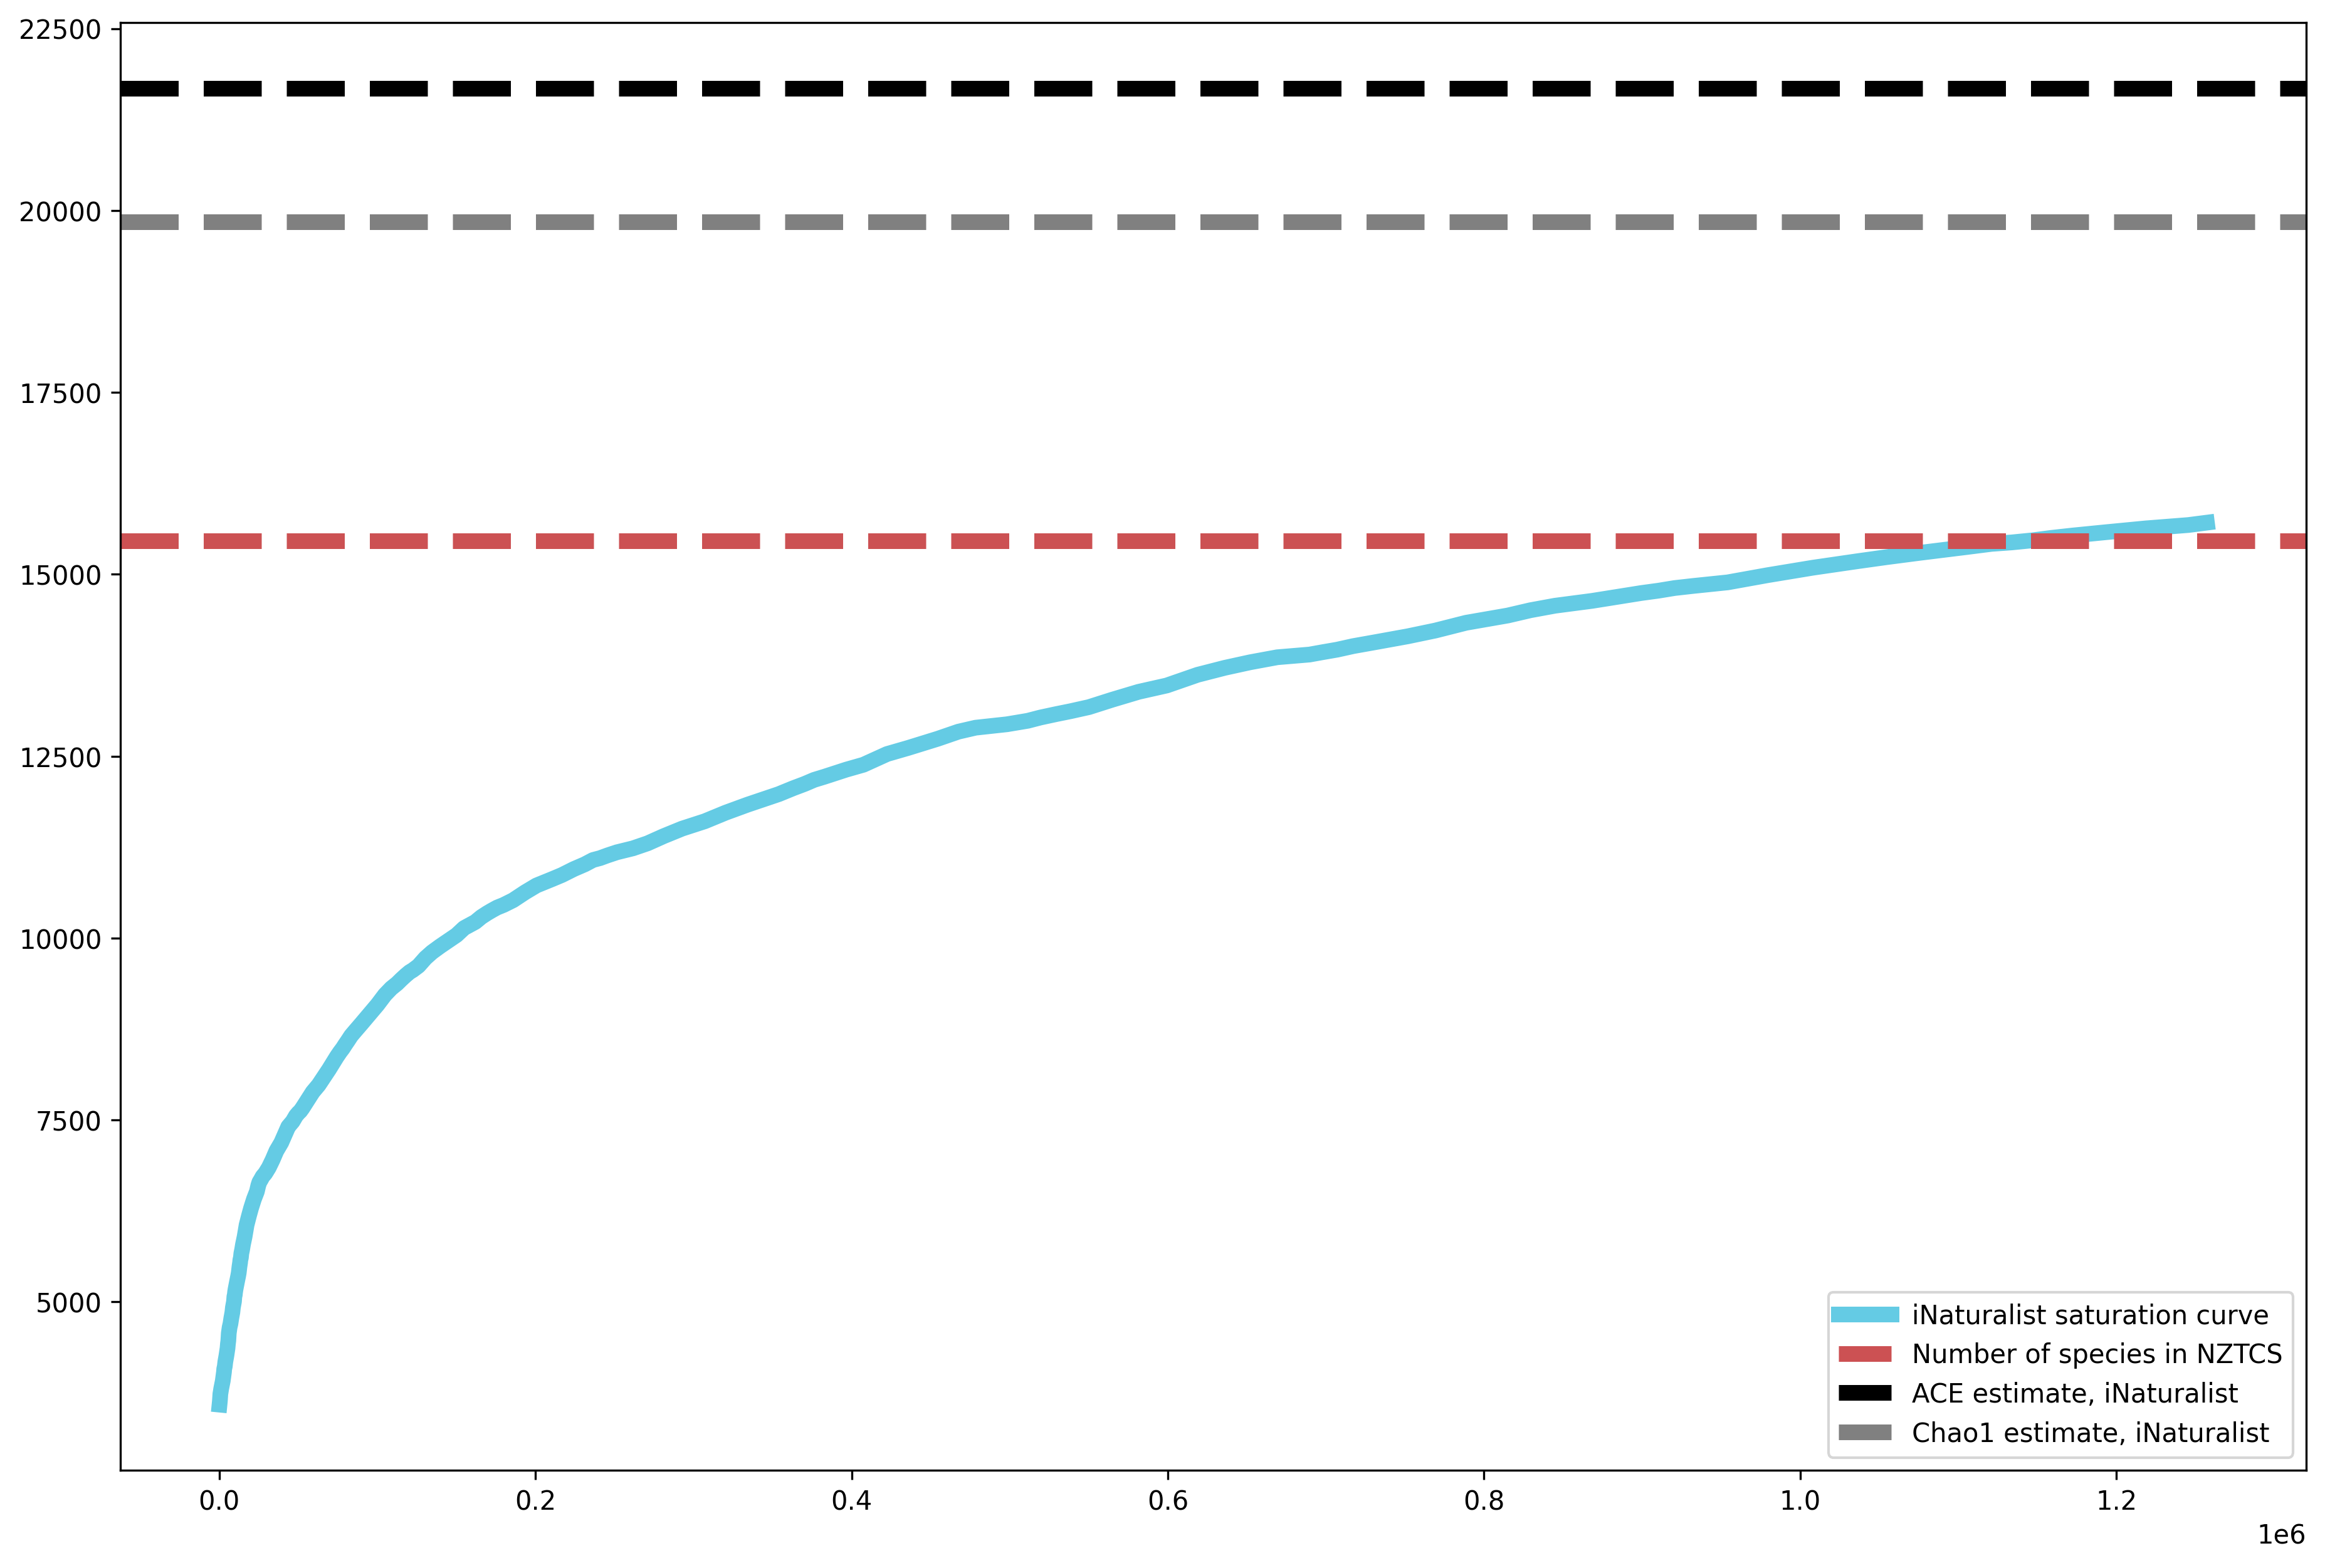

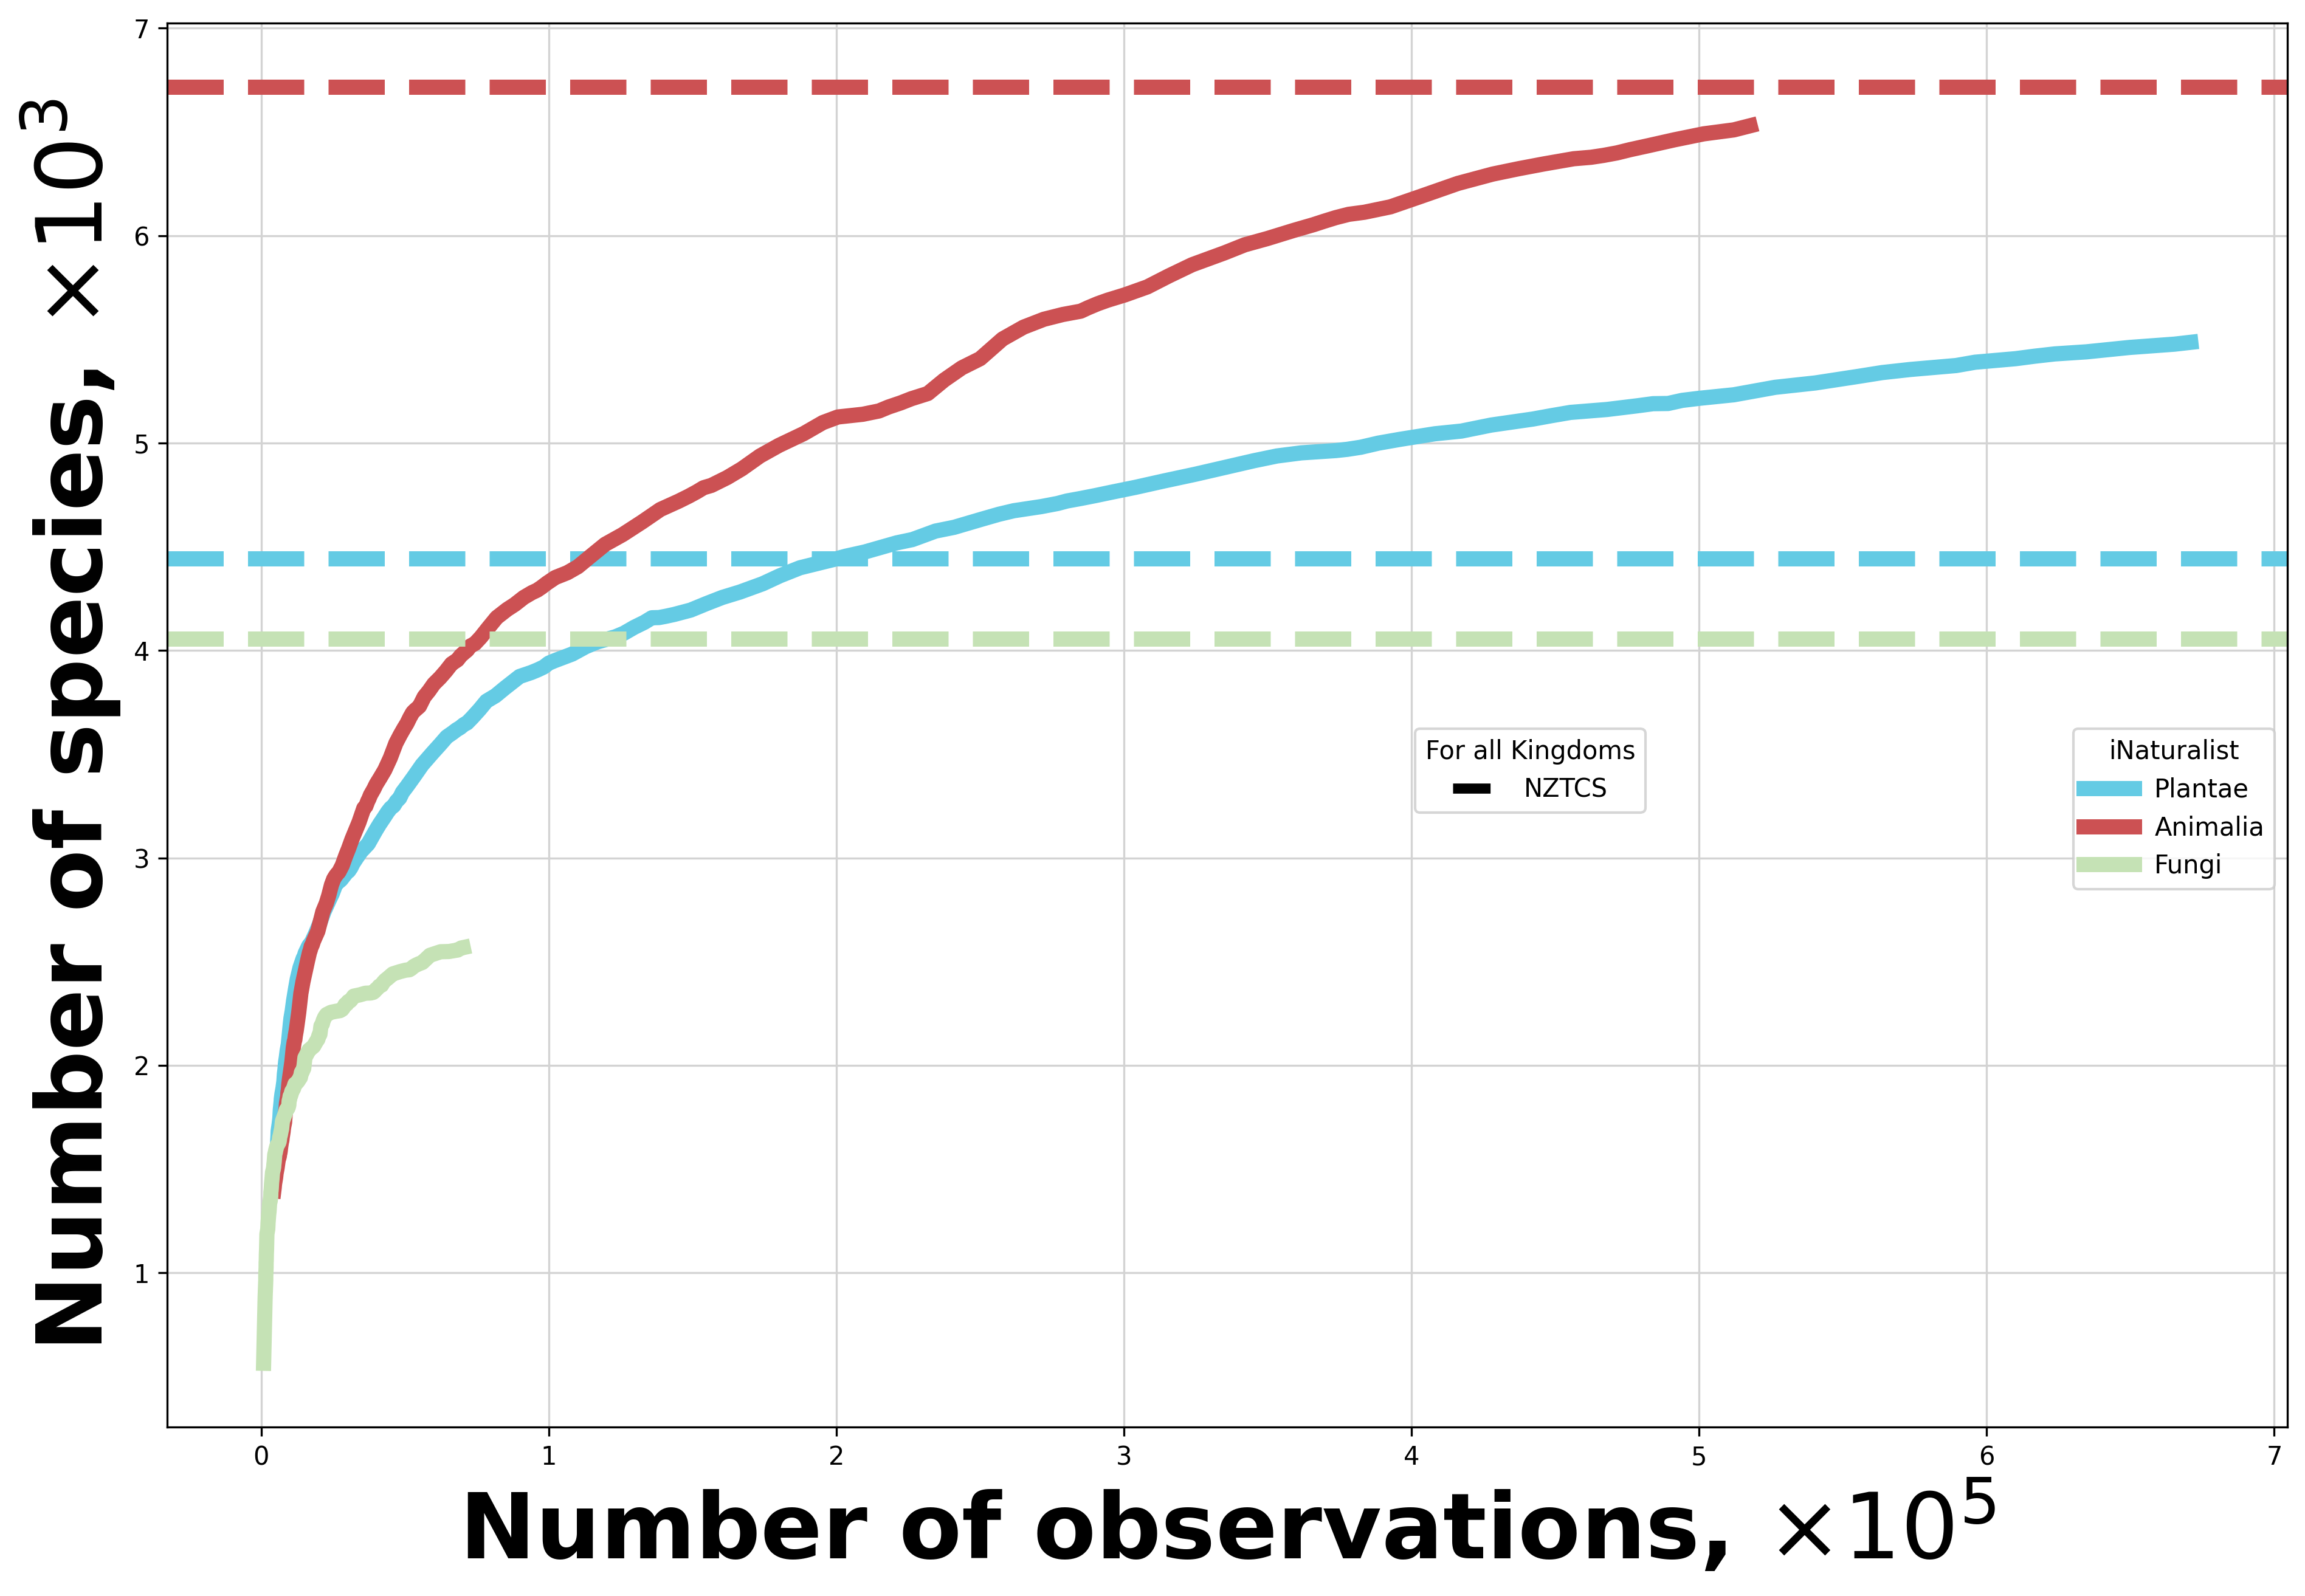

In [58]:
kingdoms = ['Plantae', 'Animalia', 'Fungi']
colors = ['#64cbe4', '#cc5153', '#c5e2b5', '#9959a4']
fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=300)
for i in range(len(kingdoms)):
    inat_observations_plants = inat_observations_by_kingdom[inat_observations_by_kingdom['kingdom']==kingdoms[i]]

    inat_observations_plants.reset_index(drop=True, inplace=True)

    # get number of rows per eventDate
    inat_observations_plants_count_observations = inat_observations_plants.groupby('eventDate').size()
    inat_observations_plants_count_observations = inat_observations_plants_count_observations.reset_index()
    inat_observations_plants_count_observations.columns = ['eventDate', 'count']
    # add cumulative sum
    inat_observations_plants_count_observations['cumulative'] = inat_observations_plants_count_observations['count'].cumsum()

    # get all the first occurences of a unique species and their date
    inat_observations_plants_count_species = inat_observations_plants.groupby('scientificName')['eventDate'].min()
    # sort by date
    inat_observations_plants_count_species = inat_observations_plants_count_species.sort_values()
    inat_observations_plants_count_species = inat_observations_plants_count_species.reset_index()
    inat_observations_plants_count_species.columns = ['scientificName', 'first_occurence']
    # group by month and count the number of occurences
    inat_observations_plants_count_species = inat_observations_plants_count_species.groupby('first_occurence').size()
    inat_observations_plants_count_species = inat_observations_plants_count_species.reset_index()
    # get cumulative sum
    inat_observations_plants_count_species['cumulative'] = inat_observations_plants_count_species[0].cumsum()
    inat_observations_plants_count_species['first_occurence'] = inat_observations_plants_count_species['first_occurence'].dt.to_period('M').dt.to_timestamp()

    # drop all dates before 2008 in inat_nz_date
    inat_observations_plants_count_observations = inat_observations_plants_count_observations[inat_observations_plants_count_observations['eventDate'] > datetime.datetime(2008, 1, 1)]
    # drop all dates before 2008 in first_occurences
    inat_observations_plants_count_species = inat_observations_plants_count_species[inat_observations_plants_count_species['first_occurence'] > datetime.datetime(2008, 1, 1)]
    # get the minimum length of the two
    min_length = min(len(inat_observations_plants_count_observations), len(inat_observations_plants_count_species))
    # create two x axis
    plt.plot(inat_observations_plants_count_observations['cumulative'][0:min_length], inat_observations_plants_count_species['cumulative'][0:min_length], label=kingdoms[i], color=colors[i], lw=6)
    # plot horizontal line for the number of unique species from nz_stats
    # calculate the number of species with kingdom = kingdom in nz_stats
    species_count_nz_stats_kingdom = nz_stats[nz_stats['Kingdom'] == kingdoms[i]]['Current Species Name'].nunique()
    plt.axhline(y=species_count_nz_stats_kingdom, linestyle='--', lw=6, label=f'Number of {kingdoms[i]} in NZ Stats', color=colors[i])
    # reformat xticks to be x*10^5

# add custom legend with Line2D: solid line represents iNaturalist, dashed line represents NZ Stats. Different colors represent different kingdoms
legend_elements = [Line2D([0], [0], color=colors[0], lw=6, label='Plantae'),
                   Line2D([0], [0], color=colors[1], lw=6, label='Animalia'),
                   Line2D([0], [0], color=colors[2], lw=6, label='Fungi')]
fig.legend(handles=legend_elements, title='iNaturalist', bbox_to_anchor=(0.9,0.5))
# add legend for NZ Stats next to the other legend
fig.legend(handles=[Line2D([0], [0], color='k', lw=4, linestyle='--', label='NZTCS')], title='For all Kingdoms', bbox_to_anchor=(0.67,0.5))
plt.xlabel('Number of observations, $×10^5$', fontweight='bold', fontsize=36)
plt.ylabel('Number of species, $×10^3$', fontweight='bold', fontsize=36)
# lightgrey grid
plt.grid(True, color='lightgrey')
# change yticklabels to be x*10^3
yticks = ax.get_yticks()
yticks = [int(ytick/1000) for ytick in yticks]
ax.set_yticklabels(yticks)
# change xticklabels to be x*10^5
xticks = ax.get_xticks()
xticks = [int(xtick/100000) for xtick in xticks]
ax.set_xticklabels(xticks)
plt.show()



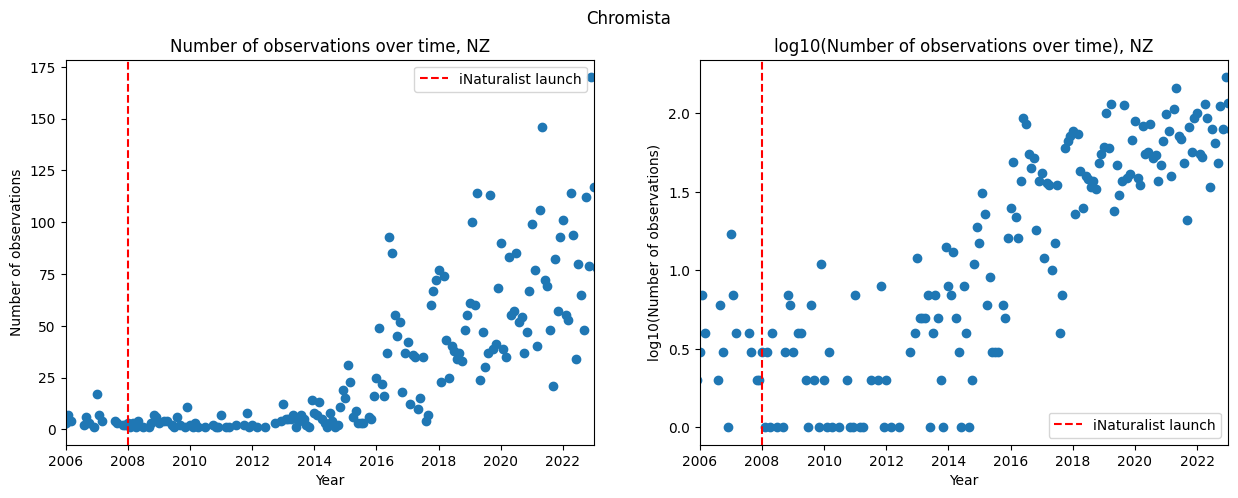

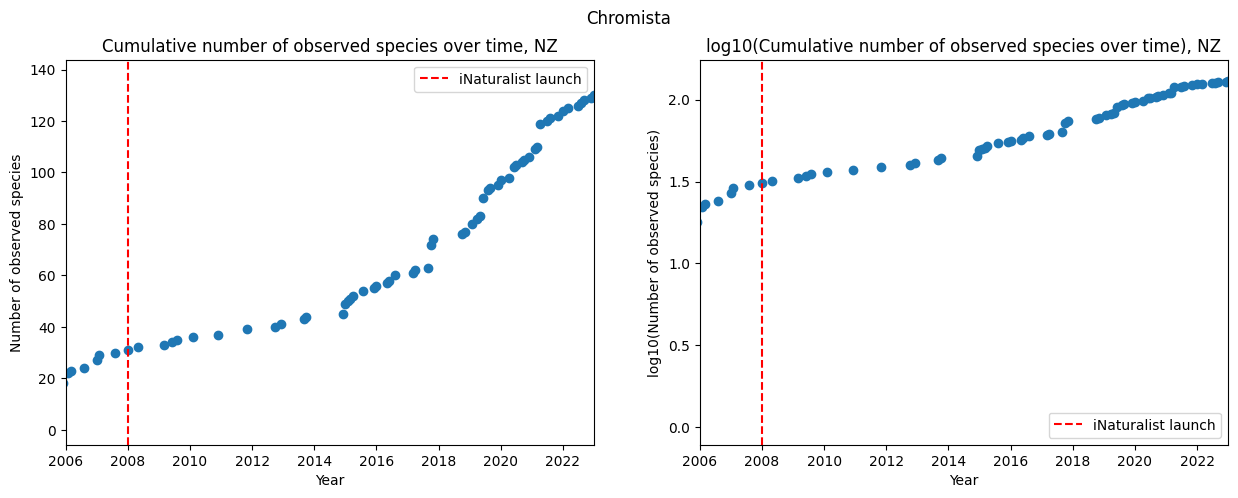

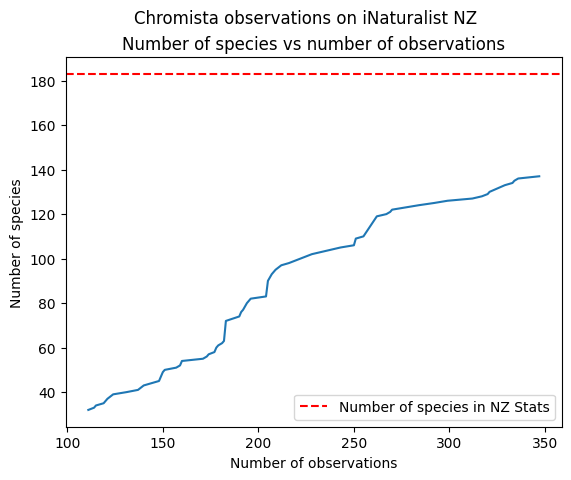

In [59]:
sat_curve_kingdom('Chromista')

# 5. Comparison of observed species by kingdom

In [60]:
species_count_kingdom = inat_nz.groupby('kingdom')['scientificName'].nunique()
species_count_kingdom = species_count_kingdom.reset_index()
species_count_kingdom.columns = ['kingdom', 'count']
# sort by kingdom
species_count_kingdom = species_count_kingdom.sort_values(by='count', ascending=False)
species_count_kingdom = species_count_kingdom.reset_index(drop=True)
# get sum of count
print(species_count_kingdom['count'].sum())

15710


In [61]:
# normalise the data in a new dataframe
species_count_kingdom_norm = species_count_kingdom.copy()
species_count_kingdom_norm['prob'] = species_count_kingdom_norm['count'] / species_count_kingdom_norm['count'].sum()
# drop count
species_count_kingdom_norm = species_count_kingdom_norm.drop(columns='count')
nz_stats_kingdom_norm = nz_stats_kingdom.copy()
nz_stats_kingdom_norm['prob'] = nz_stats_kingdom_norm['count'] / nz_stats_kingdom_norm['count'].sum()
# drop count
nz_stats_kingdom_norm = nz_stats_kingdom_norm.drop(columns='count')


NameError: name 'nz_stats_kingdom' is not defined

In [ ]:
# calculate the standard deviation of the probability of each kingdom if this is a binomial
species_count_kingdom_norm['std'] = np.sqrt(species_count_kingdom_norm['prob'] * (1 - species_count_kingdom_norm['prob']) / species_count_inat)

In [ ]:
# calculate the z-score
species_count_kingdom_norm['z'] = (species_count_kingdom_norm['prob'] - nz_stats_kingdom_norm['prob']) / species_count_kingdom_norm['std']

In [ ]:
# calculate the two-tailed p-value
species_count_kingdom_norm['p'] = stats.norm.sf(abs(species_count_kingdom_norm['z'])) * 2

In [ ]:
species_count_kingdom_norm

,kingdom,prob,std,z,p
0,Animalia,0.433291,0.003954,-0.348860,7.271943e-01
1,Plantae,0.386633,0.003885,25.544130,6.380402e-144
2,Fungi,0.164736,0.002959,-33.028585,3.158316e-239
3,Chromista,0.008721,0.000742,-4.201230,2.654691e-05
4,Protozoa,0.003756,0.000488,0.273186,7.847103e-01
5,Bacteria,0.002292,0.000381,NaN,NaN
6,Viruses,0.000573,0.000191,NaN,NaN


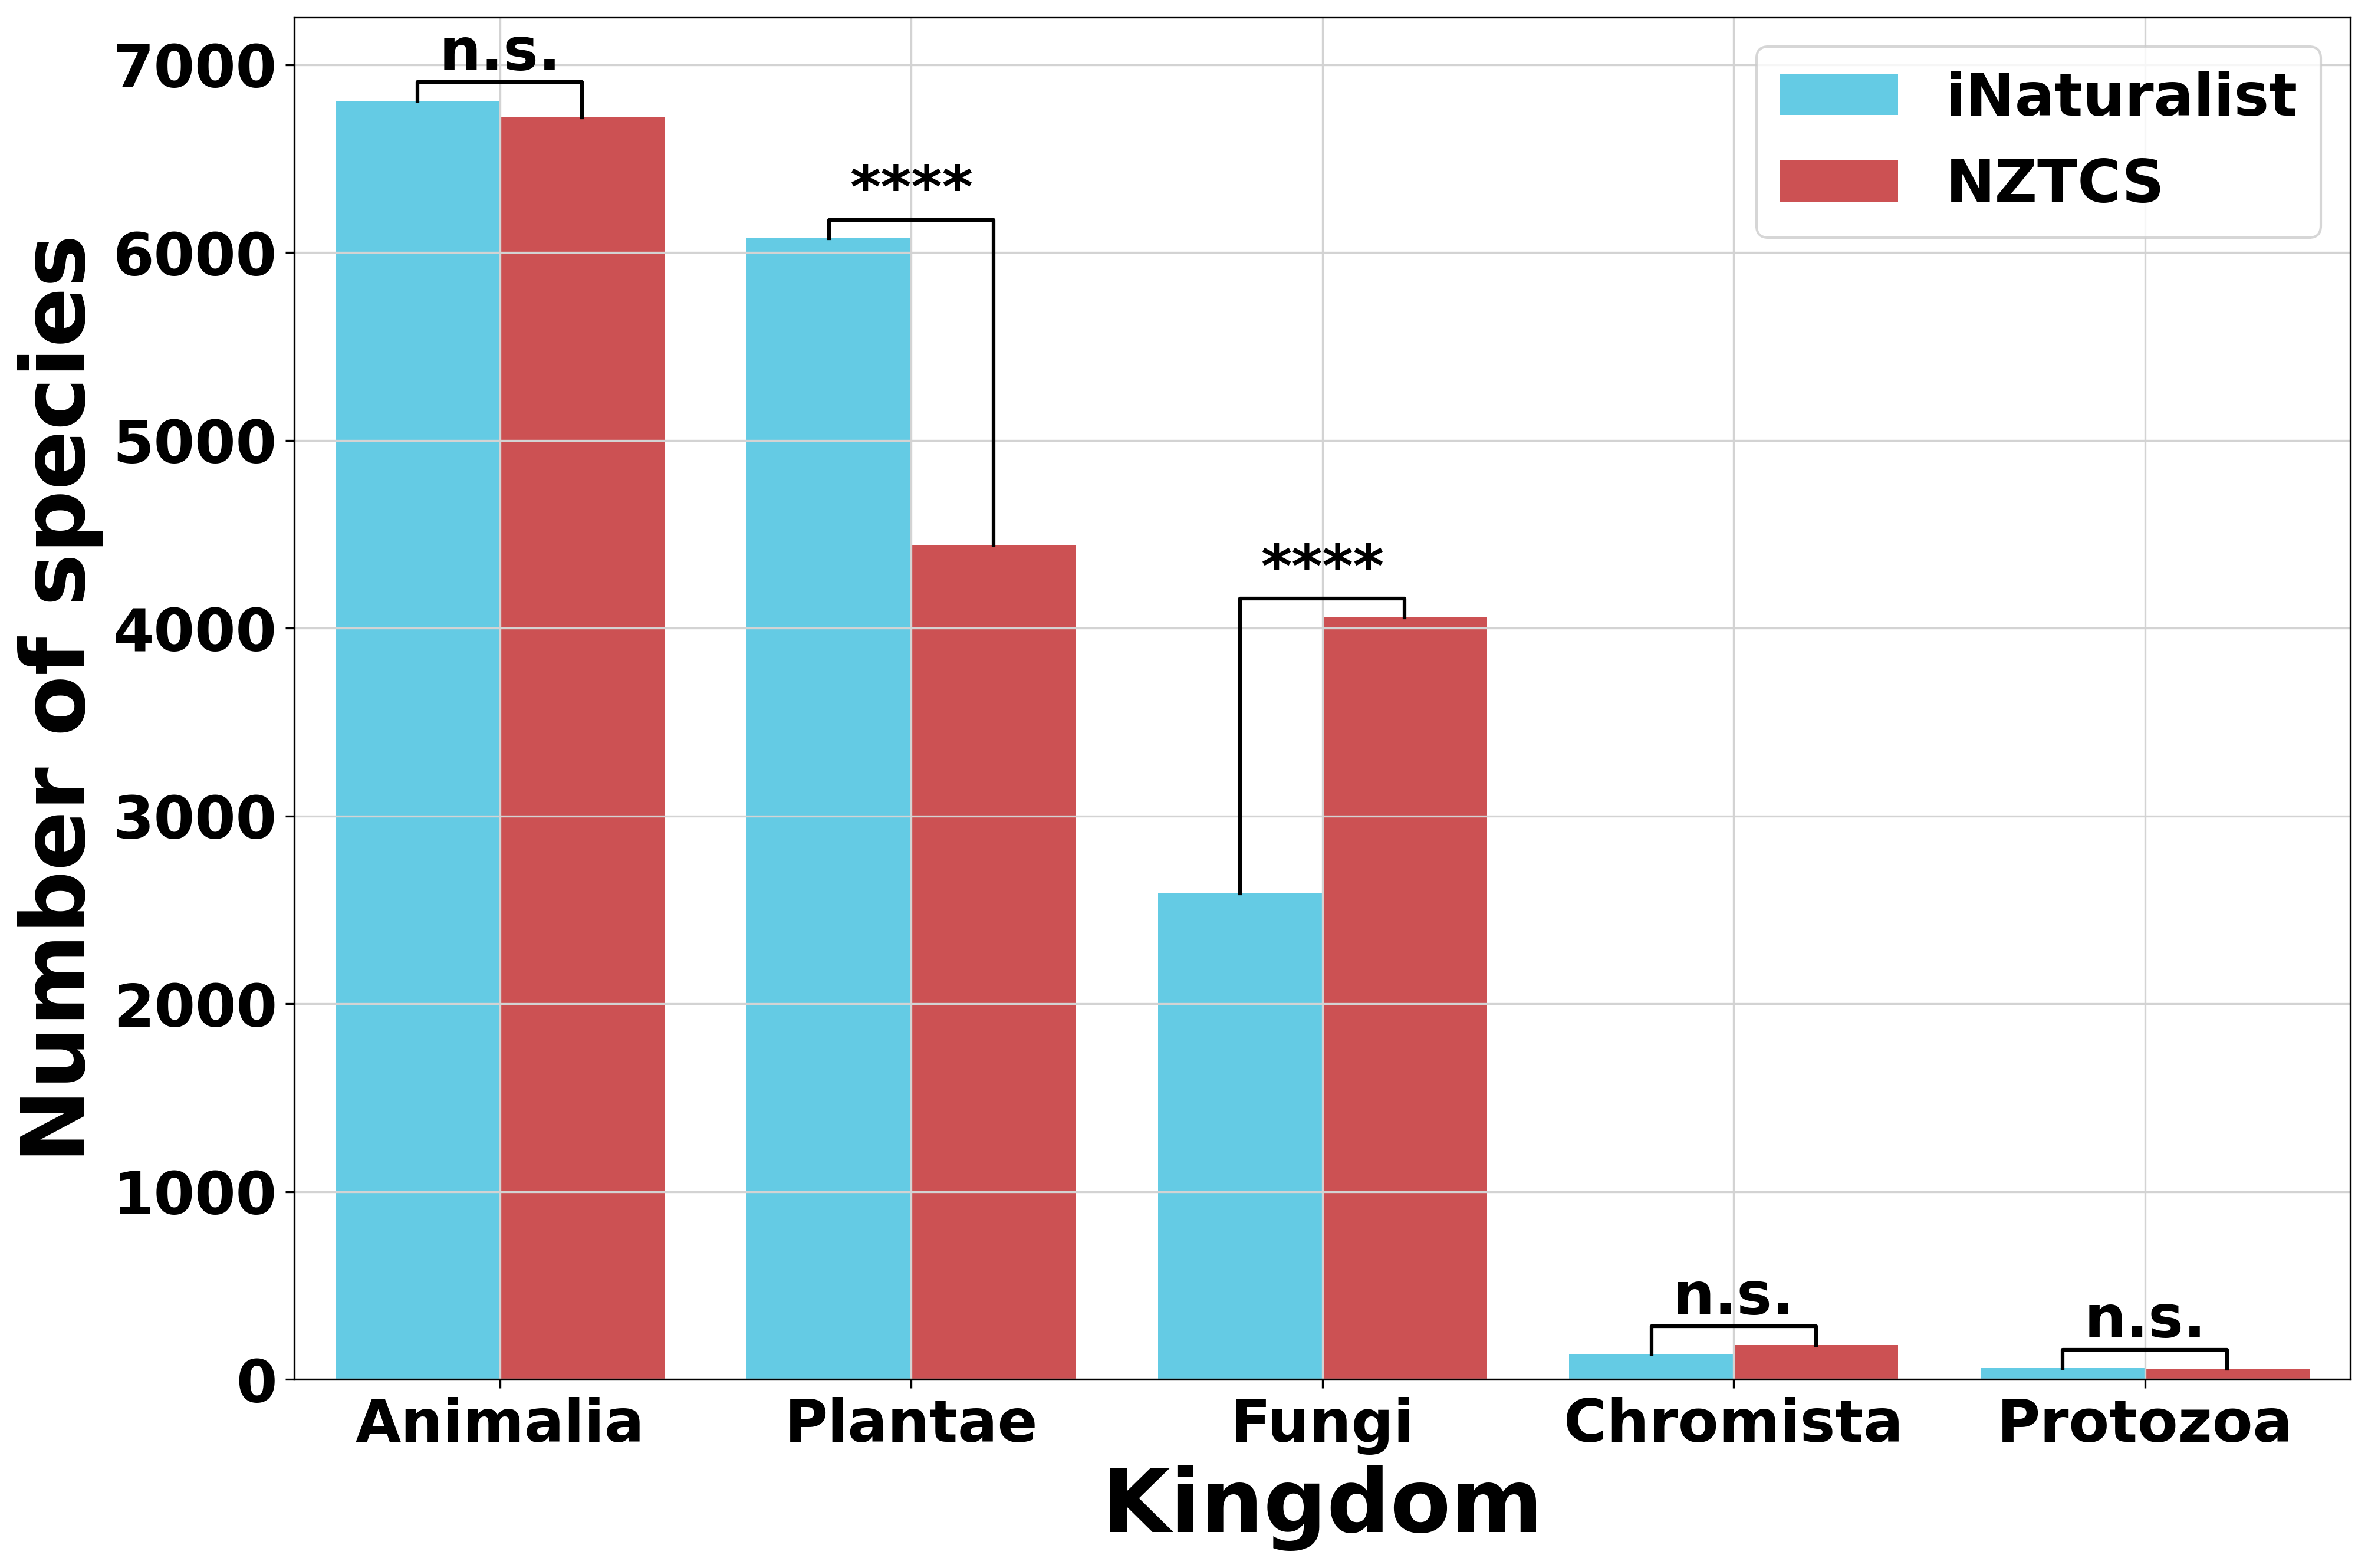

In [ ]:
# group nz_stats by kingdom and count the number of species
nz_stats_kingdom = nz_stats['Kingdom'].value_counts()
nz_stats_kingdom = nz_stats_kingdom.reset_index()
nz_stats_kingdom.columns = ['kingdom', 'count']
# sort by kingdom
nz_stats_kingdom = nz_stats_kingdom.sort_values(by='count', ascending=False)
nz_stats_kingdom = nz_stats_kingdom.reset_index(drop=True)

# plot using plt instead of plot.bar next to one another, with different x values
X_axis_inat = np.arange(len(species_count_kingdom['kingdom']))
X_axis_nz = np.arange(len(nz_stats_kingdom['kingdom']))
X_labels = species_count_kingdom['kingdom']

plt.figure(figsize=(15, 10), dpi=300)
plt.gca().set_facecolor('None')
plt.bar(X_axis_inat - 0.2, species_count_kingdom['count'], 0.4, label='iNaturalist', color='#64cbe4')
plt.bar(X_axis_nz + 0.2, nz_stats_kingdom['count'], 0.4, label='NZTCS', color='#cc5153')
plt.xticks(X_axis_inat, X_labels)

plt.text((X_axis_inat[0]), species_count_kingdom['count'][0] + 100, 'n.s.', ha='center', va='bottom', fontsize=24)
plt.text((X_axis_inat[1]), species_count_kingdom['count'][1] + 100, '****', ha='center', va='bottom',  fontsize=24)
plt.text((X_axis_inat[2]), nz_stats_kingdom['count'][2] + 100, '****', ha='center', va='bottom', fontsize=24)
plt.text((X_axis_inat[3]), nz_stats_kingdom['count'][3] + 100, 'n.s.', ha='center', va='bottom',  fontsize=24)
plt.text((X_axis_inat[4]), species_count_kingdom['count'][4] + 100, 'n.s.', ha='center', va='bottom',  fontsize=24)

# exclude the last two, since they're absent in iNaturalist
# plt.text((X_axis_inat[5]), species_count_kingdom['count'][5] + 100, 'nan', ha='center', va='bottom', color='black')
# plt.text((X_axis_inat[6]), species_count_kingdom['count'][6] + 100, 'nan', ha='center', va='bottom', color='black')

for i in range(len(species_count_kingdom['kingdom'])):
    x = X_axis_inat[i]
    if i == 2 or i == 3:
        plt.plot([x-0.2, x-0.2, x+0.2, x+0.2], [species_count_kingdom['count'][i], nz_stats_kingdom['count'][i] + 100, nz_stats_kingdom['count'][i] + 100, nz_stats_kingdom['count'][i]], lw=1.5, c='k')
    elif i >= 5:
        plt.plot([x-0.2, x-0.2, x+0.2, x+0.2], [species_count_kingdom['count'][i], species_count_kingdom['count'][i] + 100, species_count_kingdom['count'][i] + 100, species_count_kingdom['count'][i]], lw=1.5, c='k')
    else:
        plt.plot([x-0.2, x-0.2, x+0.2, x+0.2], [species_count_kingdom['count'][i], species_count_kingdom['count'][i] + 100, species_count_kingdom['count'][i] + 100, nz_stats_kingdom['count'][i]], lw=1.5, c='k')

plt.legend()
# plt.title('Number of species per kingdom')
plt.xlabel('Kingdom', fontsize=36, fontweight='bold')
plt.ylabel('Number of species', fontsize=36, fontweight='bold')
plt.xlim(-0.5, 4.5)

plt.gca().set_facecolor((1,1,1,0.5))
# turn on grid in light grey
plt.grid(True, color='lightgrey')

plt.show()